<a href="https://colab.research.google.com/github/ravi7299/mask-detector/blob/master/train_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset link https://datasetsforml.s3.ap-south-1.amazonaws.com/facemask_dataset.zip

In [7]:
!wget --no-check-certificate \
    https://datasetsforml.s3.ap-south-1.amazonaws.com/facemask_dataset.zip \
    -O facemask_dataset.zip

--2020-07-14 00:45:07--  https://datasetsforml.s3.ap-south-1.amazonaws.com/facemask_dataset.zip
Resolving datasetsforml.s3.ap-south-1.amazonaws.com (datasetsforml.s3.ap-south-1.amazonaws.com)... 52.219.64.123
Connecting to datasetsforml.s3.ap-south-1.amazonaws.com (datasetsforml.s3.ap-south-1.amazonaws.com)|52.219.64.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52826029 (50M) [application/zip]
Saving to: ‘facemask_dataset.zip’

facemask_dataset.zi 100%[===================>]  50.38M  19.0MB/s    in 2.7s    

2020-07-14 00:45:10 (19.0 MB/s) - ‘facemask_dataset.zip’ saved [52826029/52826029]



In [8]:
import os
import zipfile

local_zip = 'facemask_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [10]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [12]:
data_path="./dataset"

imagePaths = list(paths.list_images(data_path))
data = []
labels = []

In [14]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

In [15]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [16]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [17]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [18]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [19]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [20]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [22]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [23]:
for layer in baseModel.layers:
	layer.trainable = False

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [25]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 15s 447ms/step - loss: 0.6160 - accuracy: 0.6938 - val_loss: 0.1862 - val_accuracy: 0.9638
Epoch 2/20
34/34 [==============================] - 13s 388ms/step - loss: 0.1878 - accuracy: 0.9410 - val_loss: 0.0796 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 13s 392ms/step - loss: 0.1020 - accuracy: 0.9738 - val_loss: 0.0476 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 14s 401ms/step - loss: 0.0749 - accuracy: 0.9844 - val_loss: 0.0339 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 13s 386ms/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0263 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 13s 386ms/step - loss: 0.0450 - accuracy: 0.9906 - val_loss: 0.0215 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 13s 391ms/step - loss: 0.0381 - accuracy: 0.9871 - val_loss: 0.0186 - val_accuracy: 0.9928

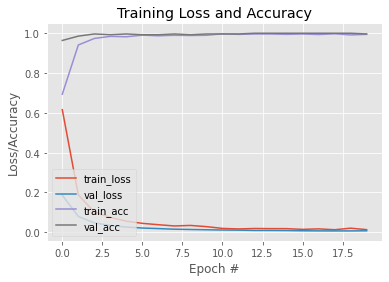

In [26]:
model.save("mask_detector.model", save_format="h5")

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("mask_detector_plot.jpg")

In [27]:
from google.colab import files

files.download("mask_detector.model")
files.download("mask_detector_plot.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>